In [ ]:
#@InProceedings{wang2017chestxray,
    #author = {Wang, Xiaosong and Peng, Yifan and Lu, Le and Lu, Zhiyong and Bagheri, Mohammadhadi
    #and Summers, Ronald},
    #title = {ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised
    #Classification and Localization of Common Thorax Diseases},
    #booktitle = {2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)},
    #pages = {3462--3471},
    #year = {2017}
#}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 7010 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
220/220 [==============================] - 61s 261ms/step - loss: 2.6309 - accuracy: 0.1208 - val_loss: 2.4838 - val_accuracy: 0.1422
Epoch 2/10
220/220 [==============================] - 54s 244ms/step - loss: 2.4783 - accuracy: 0.1536 - val_loss: 2.4659 - val_accuracy: 0.1500
Epoch 3/10
220/220 [==============================] - 53s 236ms/step - loss: 2.4456 - accuracy: 0.1718 - val_loss: 2.4764 - val_accuracy: 0.1391
Epoch 4/10
220/220 [==============================] - 51s 228ms/step - loss: 2.4064 - accuracy: 0.1825 - val_loss: 2.3743 - val_accuracy: 0.2516
Epoch 5/10
220/220 [==============================] - 52s 232ms/step - loss: 2.3844 - accuracy: 0.1950 - val_loss: 2.3740 - val_accuracy: 0.2625

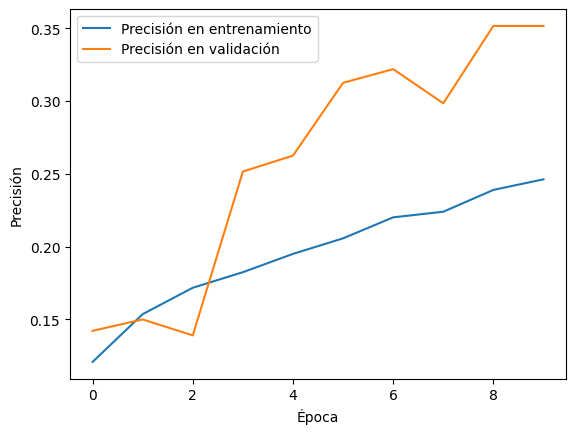

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/My Drive/Filtrado_subcarpetas/train"
test_dir = "/content/drive/My Drive/Filtrado_subcarpetas/test"

# Creacion de batches y size
batch_size = 32
img_height = 224
img_width = 224

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

val_ds = test_ds.take(20)
test_ds = test_ds.skip(20)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento con validación
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Evaluación en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}")


import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

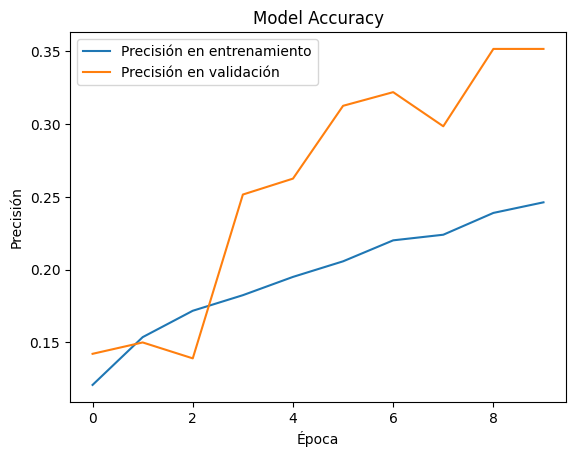

In [ ]:
# Graficamos el desempeño del entrenamiento
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
# Obtenemos el promedio de val_accuracy

val_accuracy = history.history['val_accuracy']
promedio_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print(f"El promedio de val_accuracy es: {promedio_val_accuracy}")

El promedio de val_accuracy es: 0.2581250011920929


In [ ]:
# Guardamos el modelo

model.save('modelo_entrenado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)               

In [ ]:
from google.colab import files
files.download('modelo_entrenado.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class_names = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Effusion",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumothorax"
]

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)



74/74 [==============================] - 19s 216ms/step
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00         0
      Cardiomegaly       0.00      0.00      0.00         0
     Consolidation       0.27      0.40      0.32       260
          Effusion       0.30      0.19      0.23       300
      Infiltration       0.26      0.15      0.19       300
              Mass       0.22      0.19      0.21       300
        No Finding       0.26      0.27      0.26       300
            Nodule       0.23      0.21      0.22       300
Pleural_Thickening       0.24      0.12      0.16       300
      Pneumothorax       0.35      0.30      0.32       300

          accuracy                           0.23      2360
         macro avg       0.21      0.18      0.19      2360
      weighted avg       0.27      0.23      0.24      2360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
